In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
N = 4
Arand = np.random.choice([0,1], size=(N,N), replace=True, p=[0.3,0.7])
Atriu = np.triu(Arand ,k=1)

A = Atriu.T + Atriu # Adjancey Matrix

print("Adjancey Matrix")
print(A)


Adjancey Matrix
[[0 0 0 0]
 [0 0 1 1]
 [0 1 0 1]
 [0 1 1 0]]


In [3]:
p = 4
Arand = np.random.choice([0,1], size=(p,p), replace=True, p=[0.3,0.7])
Atriu = np.triu(Arand ,k=1)

A = Atriu.T + Atriu # Adjancey Matrix

print("A")
print(A)



Aw = np.zeros_like(A)
wn = np.arange(1, p*(p-1)//2 + 1, dtype=float)

for i in range(0,p-1):

    for j in range(0,p-1):
        base = j * (2*p - j - 1) // 2
        dj =  base + (i - j - 1)

        if i > j:
            Aw[i,j] = -wn[i+dj]
        elif i < j:
            Aw[i,j] = Aw[j,i]
        else:
            Aw[i,j] = 0

print("")
print("Aw")
print(Aw)

A
[[0 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 0]]

Aw
[[ 0  0  0  0]
 [-2  0  0  0]
 [-4 -6  0  0]
 [ 0  0  0  0]]


In [124]:

def _tri_index(i, j, p):
    """
    0-based index of the pair (i>j) in a length p(p-1)/2 vector w,
    when we enumerate column-by-column down the strict lower triangle:
      (1,0)->0, (2,0)->1, ..., (p-1,0)->p-2,
      (2,1)->..., etc.
    """
    # number of items in all previous columns (0..j-1):
    base = j * (2*p - j - 1) // 2
    # offset within this column:
    return base + (i - j - 1)

def A_from_w(w, p, sign=-1):
    """
    Build A w (symmetric p×p). 'sign' lets you match the paper’s formula:
      sign=-1 -> [Aw]_{ij} = -w_k for i>j (as in the definition)
      sign=+1 -> positive version (like the example table)
    """
    w = np.asarray(w).ravel()
    m = p*(p-1)//2
    if w.size != m:
        raise ValueError(f"w must have length {m} for p={p}, got {w.size}")

    M = np.zeros((p, p), dtype=w.dtype)
    for j in range(p-1):
        for i in range(j+1, p):
            k = _tri_index(i, j, p)
            M[i, j] = sign * w[k]
            M[j, i] = M[i, j]
    return M

def w_from_A(M, sign=-1):
    """
    Inverse of A_from_w: recover w from a symmetric matrix M built as:
        M[i, j] = sign * w[k] for i > j (and symmetrized).
    Returns w with length m = p*(p-1)//2 in the same order used by A_from_w.
    """
    M = np.asarray(M)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError("M must be a square matrix.")
    p = M.shape[0]
    m = p * (p - 1) // 2
    w = np.empty(m, dtype=M.dtype)

    for j in range(p - 1):
        for i in range(j + 1, p):
            k = _tri_index(i, j, p)
            w[k] = sign * M[i, j]   # because M[i,j] = sign * w[k]

    return w

def laplacian_from_w(w, p, sign=+1):
    """
    Compute Laplacian L from weight vector w.
    sign=+1 matches the example in the paper's adjacency matrix table.
    """
    W = A_from_w(w, p, sign=sign)
    degrees = np.sum(W, axis=1)
    L = np.diag(degrees) - W
    return L




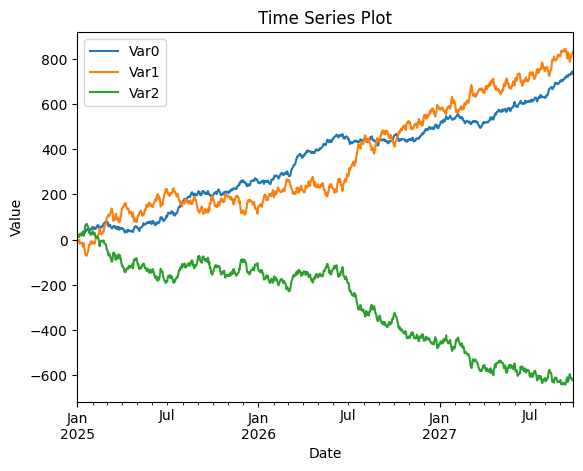

In [88]:
p = 3

var_Names = ["Var"+str(i) for i in range(0,p)]

# Random means between -1 and 1
mean = np.random.uniform(-1, 1, size=p)

# Random matrix
A = np.random.normal(loc=0.0, scale=5.0, size=(p,p))

# Positive-definite covariance matrix
cov = A.T @ A   


n_timesteps = 1000  # length of time series

# Generate the time series
data = np.random.multivariate_normal(mean, cov, size=n_timesteps)

# Put into a DataFrame for clarity
time_index = pd.date_range("2025-01-01", periods=n_timesteps, freq="D")
df = pd.DataFrame(data, columns=var_Names , index=time_index)
df_rw = df.cumsum()
# Quick plot
df_rw.plot()  # default: line plot for each column
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


In [ ]:
nFrames = 10
k = 1

X_rw = df_rw.to_numpy()     # To Numpy



nFrameIdx = np.linspace(0,X_rw.shape[0],nFrames+1,dtype=np.int64)

corr_X = np.zeros(( p, p, nFrames))
Sinv = np.zeros(( p, p, nFrames))

off_diag_elems = p*(p-1)//2
print("number of off-diag elems: ",off_diag_elems) 
winit = np.zeros(( off_diag_elems, nFrames))
w = np.zeros(( off_diag_elems, nFrames))
A0 = np.zeros(( p, p, nFrames))

Lw = np.zeros(( p, p, nFrames))
Aw = np.zeros(( p, p, nFrames))
U  = np.zeros(( p, k, nFrames))

for i in range(0,nFrames):

    corr_X[:,:,i] = np.corrcoef(X_rw[nFrameIdx[i]:nFrameIdx[i+1],:], rowvar=False) # Variables are on Columns
    Sinv = np.linalg.pinv(corr_X[:,:,i])

    wt = -Sinv[np.tril_indices_from(Sinv, k=-1)]
    wt[wt<0] = 0
    winit[:,i] = wt

    
    A0[:,:,i] = A_from_w(winit[:,i], p, sign=-1)

    S = A0[:, :, i]
    row_sums = S.sum(axis=1, keepdims=True)     # shape (p, 1)

    A0[:, :, i] = np.divide(S, row_sums,
                            out=np.zeros_like(S),
                            where=row_sums != 0)
   
    w[:,i] = w_from_A(A0[:,:,i], sign=-1)

    Lw[:,:,i] = laplacian_from_w(w[:,i], p, sign=-1)
    Aw[:,:,i] = A_from_w(w[:,i], p, sign=-1)

    res = np.linalg.eigh(Lw[:,:,i])
    U[:,:,i] = res.eigenvectors[:, (p - k):p]

    a0 # VAR 

number of off-diag elems:  3


In [257]:
U[:,:,0]

array([[-0.81649658],
       [ 0.40824829],
       [ 0.40824829]])

In [208]:
res = np.linalg.eigh(Lw)
res.eigenvectors[:, (p - k):p]

array([[ 0.04832616],
       [ 0.68170407],
       [-0.73003023]])

In [204]:
print(p)
print(k)
res.eigenvectors[:, (p - k):p]

3
3


array([[-0.57735027,  0.81506518,  0.04832616],
       [-0.57735027, -0.44938427,  0.68170407],
       [-0.57735027, -0.36568091, -0.73003023]])

In [77]:
Aw = A_from_w(w, p, sign=-1)
print("A w =\n", Aw)

Lw = laplacian_from_w(w, p)
print("Laplacian matrix:\n", Lw)

A w =
 [[ 0.         -0.         -0.16041806]
 [-0.          0.         -1.24764887]
 [-0.16041806 -1.24764887  0.        ]]
Laplacian matrix:
 [[ 0.16041806  0.         -0.16041806]
 [ 0.          1.24764887 -1.24764887]
 [-0.16041806 -1.24764887  1.40806692]]


In [30]:
f = 0
lam = 0.1

Tn = data.shape[0]//nFrames



for n in range(0,nFrames):

    off_diag_mask = ~np.eye(Lw.shape[0], dtype=bool)

    f1 += -Tn*np.log(np.linalg.det(Lw))  + Tn*np.trace(sample_cov@Lw) + lam*np.sum(np.abs(Lw[off_diag_mask]))

for n in range(1,nFrames):
    Lw


NameError: name 'sample_cov' is not defined

In [31]:
data.shape[0]

100